# Convolutional Neural Networks

# Importar Librerías

In [4]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [6]:
import os
import re
from PIL import Image

# Ruta del directorio principal
imgss = "C:/Users/angel/OneDrive/Escritorio/IaA/IA/EjerciciosPy/CNNFINAL/dataset"
dirname = os.path.join(os.getcwd(), imgss)
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search(r"\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))


leyendo imagenes de  C:/Users/angel/OneDrive/Escritorio/IaA/IA/EjerciciosPy/CNNFINAL/dataset\
C:/Users/angel/OneDrive/Escritorio/IaA/IA/EjerciciosPy/CNNFINAL/dataset\bmw318dFull 1
C:/Users/angel/OneDrive/Escritorio/IaA/IA/EjerciciosPy/CNNFINAL/dataset\camarorsFull 31029
C:/Users/angel/OneDrive/Escritorio/IaA/IA/EjerciciosPy/CNNFINAL/dataset\ferrarif40Full 31035
C:/Users/angel/OneDrive/Escritorio/IaA/IA/EjerciciosPy/CNNFINAL/dataset\tsuru1Full 31050
C:/Users/angel/OneDrive/Escritorio/IaA/IA/EjerciciosPy/CNNFINAL/dataset\vochoFull 31038
Directorios leidos: 5
Imagenes en cada directorio [31030, 31035, 31050, 31038, 31049]
suma Total de imagenes en subdirs: 155202


# Creamos las etiquetas

In [7]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  155202


In [8]:
coches=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    coches.append(name[len(name)-1])
    indice=indice+1

0 bmw318dFull
1 camarorsFull
2 ferrarif40Full
3 tsuru1Full
4 vochoFull


In [9]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [10]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (124161, 80, 80, 3) (124161,)
Testing data shape :  (31041, 80, 80, 3) (31041,)


Text(0.5, 1.0, 'Ground Truth : 4')

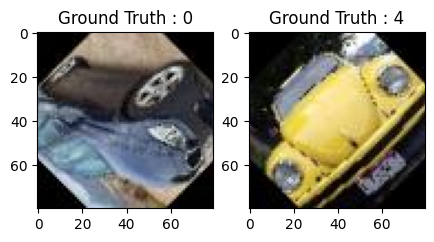

In [11]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

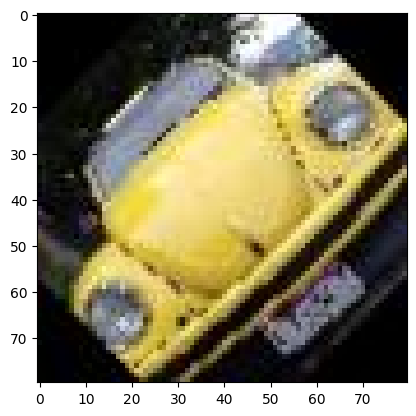

In [12]:


train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [13]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [14]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [15]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(99328, 80, 80, 3) (24833, 80, 80, 3) (99328, 5) (24833, 5)


# Creamos el modelo de CNN

In [16]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-2 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [17]:
coche_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.7),
    Dense(nClasses, activation='softmax')
])

C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
coche_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 78, 78, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 979,781 (3.74 MB)

 Trainable params: 979,781 (3.74 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
coche_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),
    metrics=['accuracy']
)

C:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# Entrenamos el modelo: Aprende a clasificar imágenes

In [20]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
coche_train = coche_model.fit(
    train_X, train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label)
)


Epoch 1/20
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 375s 241ms/step - accuracy: 0.2734 - loss: 1.5734 - val_accuracy: 0.3985 - val_loss: 1.4457
Epoch 2/20
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 359s 231ms/step - accuracy: 0.3931 - loss: 1.4297 - val_accuracy: 0.4905 - val_loss: 1.2785
Epoch 3/20
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 349s 225ms/step - accuracy: 0.4825 - loss: 1.2795 - val_accuracy: 0.5980 - val_loss: 1.0868
Epoch 4/20
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 356s 229ms/step - accuracy: 0.5681 - loss: 1.1052 - val_accuracy: 0.6674 - val_loss: 0.8872
Epoch 5/20
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 349s 225ms/step - accuracy: 0.6445 - loss: 0.9329 - val_accuracy: 0.7481 - val_loss: 0.7167
Epoch 6/20
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 352s 227ms/step - accuracy: 0.7123 - loss: 0.7697 - val_accuracy: 0.8194 - val_loss: 0.5242
Epoch 7/20
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 352s 227ms/step - accuracy: 0.7704 - loss: 0.6243 - val_accuracy: 0.8630 - val_loss: 0.4158
Epoch 8/20
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 351s 226ms/step - ac

In [21]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
datali = "C:/Users/angel/OneDrive/Escritorio/IaA/IA/EjerciciosPy/CNNFINAL/coche.keras"
coche_model.save(datali)

# Evaluamos la red

In [22]:
test_eval = coche_model.evaluate(test_X, test_Y_one_hot, verbose=1)

971/971 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9824 - loss: 0.0613


In [23]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.06100587546825409
Test accuracy: 0.9820237755775452


In [24]:
coche_train.history

{'accuracy': [0.3140604794025421,
  0.41696199774742126,
  0.5037250518798828,
  0.5851421356201172,
  0.6639013886451721,
  0.7271866798400879,
  0.7787330746650696,
  0.8201413750648499,
  0.8558915853500366,
  0.8814734816551208,
  0.902988076210022,
  0.9190359115600586,
  0.9301405549049377,
  0.9414364695549011,
  0.9478495717048645,
  0.9557526707649231,
  0.9611690640449524,
  0.9662935137748718,
  0.9702198505401611,
  0.9748811721801758],
 'loss': [1.5344783067703247,
  1.3938894271850586,
  1.2380293607711792,
  1.0651935338974,
  0.8908310532569885,
  0.7368386387825012,
  0.6015619039535522,
  0.49456673860549927,
  0.40411460399627686,
  0.33407655358314514,
  0.27688345313072205,
  0.23320280015468597,
  0.20039144158363342,
  0.169576957821846,
  0.15121479332447052,
  0.12822823226451874,
  0.11170626431703568,
  0.0977531298995018,
  0.08741214871406555,
  0.07486734539270401],
 'val_accuracy': [0.39854225516319275,
  0.4904763698577881,
  0.5980348587036133,
  0.6673

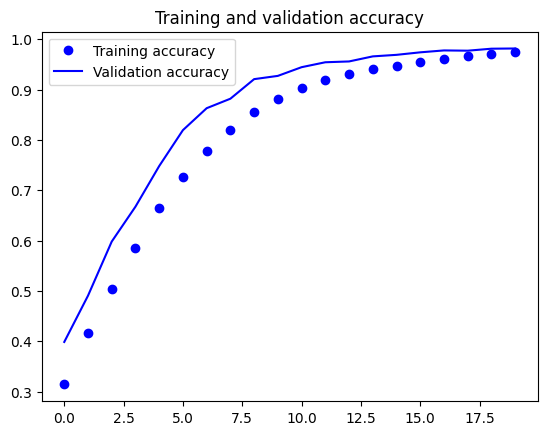

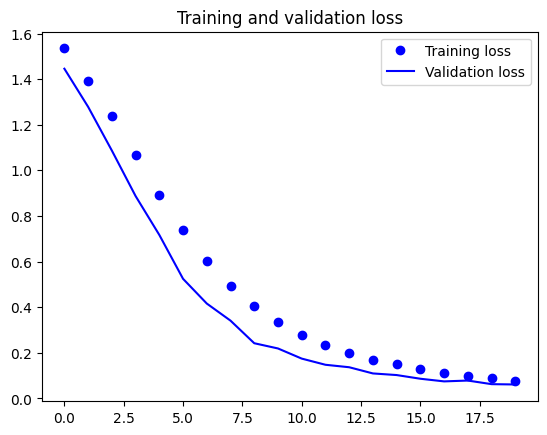

In [25]:
accuracy = coche_train.history['accuracy']
val_accuracy = coche_train.history['val_accuracy']
loss = coche_train.history['loss']
val_loss = coche_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [26]:
predicted_classes2 = coche_model.predict(test_X)

971/971 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step


In [27]:
predicted_classes=[]
for predicted_coche in predicted_classes2:
    predicted_classes.append(predicted_coche.tolist().index(max(predicted_coche)))
predicted_classes=np.array(predicted_classes)

In [28]:
predicted_classes.shape, test_Y.shape

((31041,), (31041,))

# Aprendamos de los errores: Qué mejorar

Found 30483 correct labels


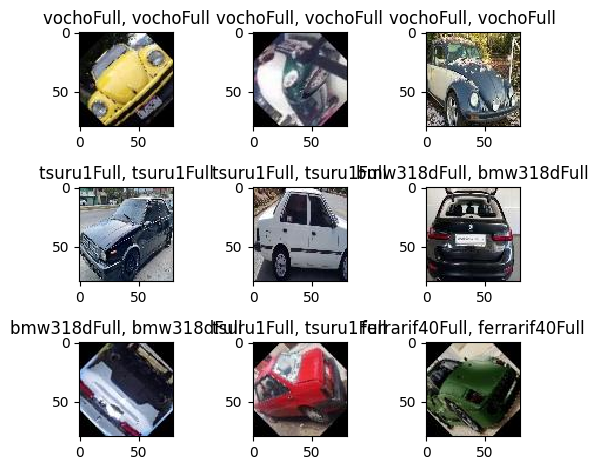

In [29]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(80,80,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(coches[predicted_classes[correct]],
                                                    coches[test_Y[correct]]))

    plt.tight_layout()

Found 558 incorrect labels


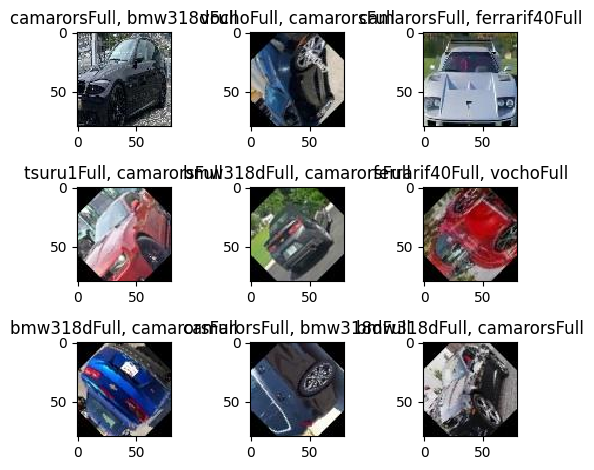

In [30]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(80,80,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(coches[predicted_classes[incorrect]],
                                                   coches[test_Y[incorrect]]))
    plt.tight_layout()

In [31]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98      6210
     Class 1       0.97      0.97      0.97      6219
     Class 2       0.99      0.99      0.99      6390
     Class 3       0.99      1.00      0.99      6132
     Class 4       0.99      0.97      0.98      6090

    accuracy                           0.98     31041
   macro avg       0.98      0.98      0.98     31041
weighted avg       0.98      0.98      0.98     31041



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.models import load_model

# Cargar imágenes
images = []
filenames = ['C:/Users/angel/OneDrive/Escritorio/IaA/IA/EjerciciosPy/CNNFINAL/r.jpg']

modelo_h5 = 'C:/Users/angel/OneDrive/Escritorio/IaA/IA/EjerciciosPy/CNNFINAL/coche30mil.keras'
coches_model = load_model(modelo_h5)

# Verificar tamaño de entrada del modelo
expected_input_shape = coches_model.input_shape[1:3]  # Altura y anchura esperadas

for filepath in filenames:
    image = plt.imread(filepath)
    # Redimensionar las imágenes al tamaño esperado por el modelo
    image_resized = resize(image, expected_input_shape, anti_aliasing=True, clip=False, preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8)  # Convertir de lista a numpy
test_X = X.astype('float32') / 255.  # Normalizar

# Predecir clases
predicted_classes = coches_model.predict(test_X)

# Etiquetas de las clases
coches_models = [ 'bmw318dFull','camarorsFull','ferrarif40Full','tsuru1Full','vochoFull']  # Cambia según corresponda

# Mostrar resultados
for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], coches_models[np.argmax(img_tagged)])